In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

from shapely import Polygon
import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [125]:
import beampipe_parameters
beampipe0=beampipe_parameters.Beampipe()

In [126]:

#def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=59.8, width=59.6,gap=0.4):
def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=60.96, width=60.96,gap=0.4):
    offsetX=-10
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    if side=="R":
        offsetX-width/2
        
        phi= np.linspace(-np.pi/2, np.pi/2, 25)
        
        x,y = [offsetX-width/2, offsetX-width/2, -gap/2, -gap/2] + list(holeX-holeR*np.cos(phi)) + [-gap/2,-gap/2, -39.8], \
                 [-height/2,height/2, height/2, holeR]+ list(-holeR*np.sin(phi))+ [-holeR,-height/2, -height/2]
        return Polygon(zip(x,y))
    if side=="L":
        
        phi0 = np.arccos((holeX-gap/2)/holeR)
        #print((np.pi-phi0)/np.pi*2)
        phi = np.linspace(phi0,2*np.pi-phi0, 13)
        
        x=[offsetX+width/2, offsetX+width/2, gap/2] + list(holeX-np.cos(phi)*holeR) + [gap/2, 19.8]
        y=[-height/2,height/2, height/2]+list(holeR*np.sin(phi)) + [-height/2, -height/2]
        return Polygon(zip(x,y))

In [127]:

def engineering_diagram(layer, beampipe=beampipe0, height=60.96, width=60.96,gap=0.4):
    fig, ax=plt.subplots(1,1,figsize=(16,16))
    plt.text(-10, 27, f"Layer {layer}", ha='center', fontsize=40)
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    for side in "LR":
        boundaries=layer_boundaries(layer, side, beampipe=beampipe, height=height, width=width, gap=0.4)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color='k', linewidth=2)
        plt.fill(*boundaries.exterior.xy, color='#33aaff11')
    offset=-10
    
    def dimension(x, y, slashlength=1, position_ratio=0.5):
        #draw line
        plt.plot(x, y,color='0.5', linestyle='-')
        #draw slashes
        for i in 0,1:
            plt.plot([x[i]-slashlength/2, x[i]+slashlength/2], 
                     [y[i]-slashlength/2, y[i]+slashlength/2], color='0.5', linestyle='-', linewidth=3)
        
        #now write the dimension
        dist = np.hypot(x[1]-x[0], y[1]-y[0])
        pr=position_ratio
        phi=-np.arctan2(y[1]-y[0], x[1]-x[0])
        plt.text(x[0]*pr+x[1]*(1-pr), y[0]*pr+y[1]*(1-pr), 
                 f"{dist:.2f} cm\n{dist/2.54:.2f}\"", ha='center', va='center',
                rotation=phi*180/np.pi)
    
    dimension([offset-width/2, offset+width/2], [-height/2+3, -height/2+3])
    
    dimension([offset-width/2+5, offset-width/2+5], [height/2, -height/2], position_ratio=0.3)

    dimension([offset-width/2, -gap/2], [20,20])
    
    dimension([gap/2, offset+width/2], [25,25])
    
    
    dimension([beampipe.holeX(layer), offset+width/2], [0,0], position_ratio=0.3)
    dimension([offset-width/2, beampipe.holeX(layer)], [0,0], position_ratio=0.6)
    
    phi=0.7*np.pi
    x=beampipe.holeX(layer)
    r=beampipe.holeR(layer)
    dimension([x+np.cos(phi)*r,x], [np.sin(phi)*r,0])
    
    #now show the gap dimensions using inward-pointing arrows
    arg=dict(color='0.5', linestyle='-')
    h=-20 #height of where the dimension goes
    ah=0.5 #arrowhead
    plt.plot([-2, -gap], [h, h], **arg)
    plt.plot([-gap-ah, -gap, -gap-ah], [h+ah, h, h-ah],**arg)
    
    plt.plot([2, gap], [h, h],**arg)
    plt.plot([gap+ah, gap, gap+ah], [h+ah, h, h-ah],**arg)
    
    plt.text(-6, h, f"{gap:.2f} cm\n{gap/2.54:.2f}\"", va='center', ha='center')
    
    
    ax.invert_xaxis()
    ax.axis("off")
    #plt.plot(
                #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

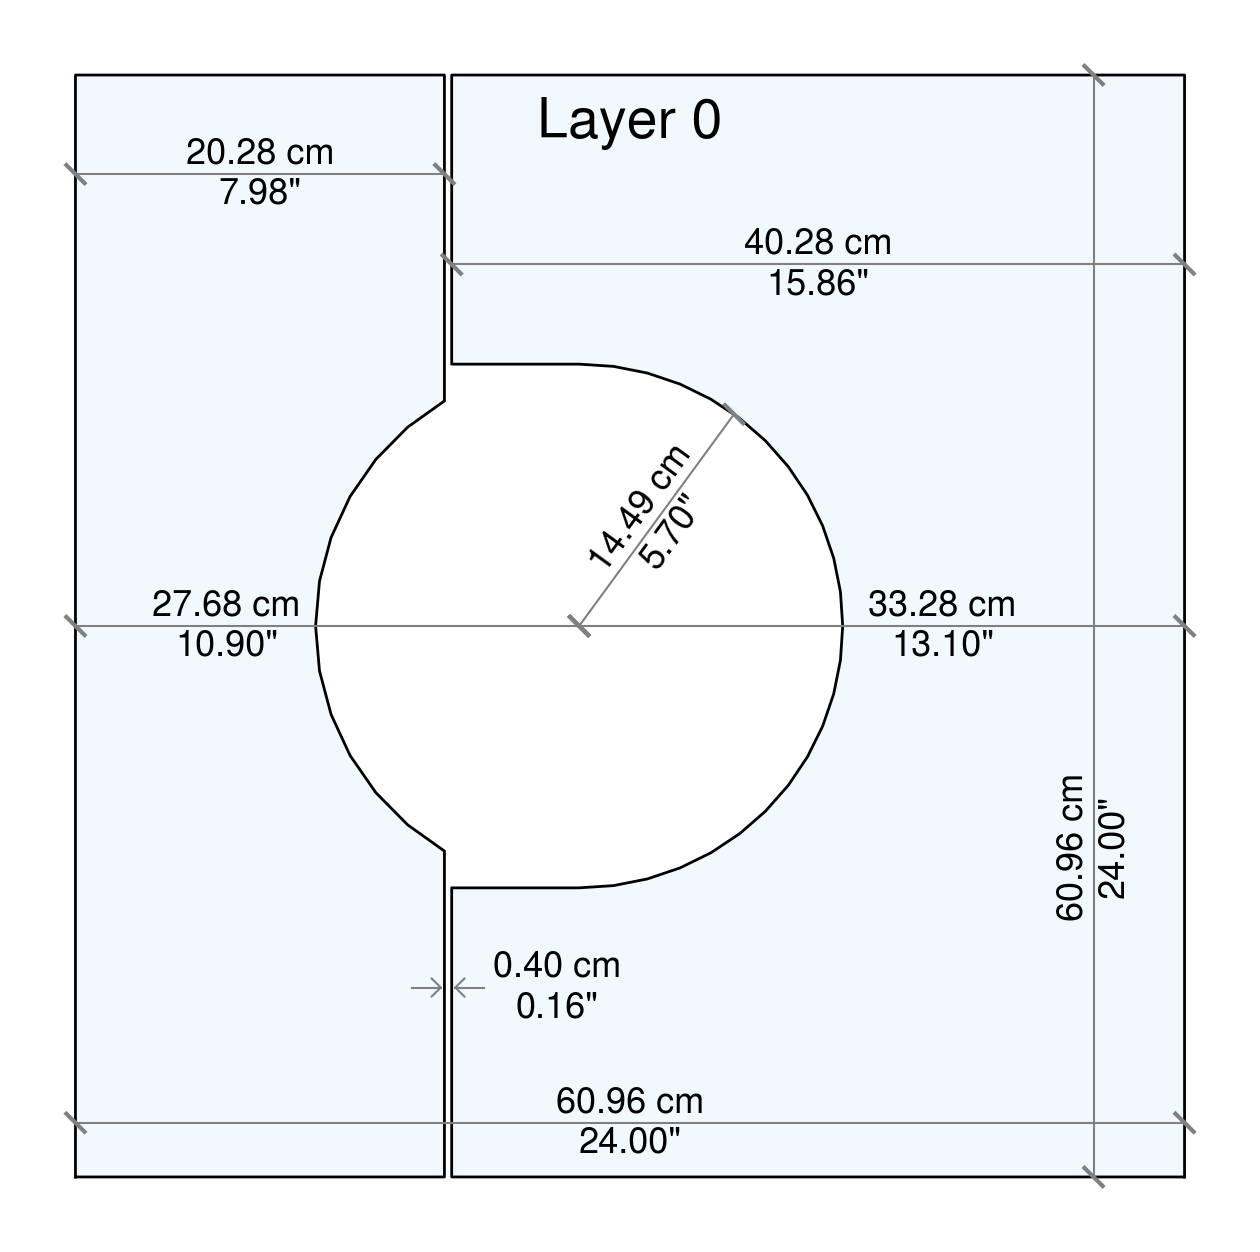

In [128]:


engineering_diagram(0, width=60.96, height=60.96)
